In [3]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import pickle
import re

In [5]:
df = pd.read_csv("/content/lending_club_dataset.csv")
data = df

In [6]:
# Get list of discrete and continuous features
discrete_features = []
continuous_features = []
for column in data.columns:
    if data[column].dtype == 'object':
        discrete_features.append(column)
    else:
        continuous_features.append(column)
# Print the lists of discrete and continuous features
print("Discrete features:")
print(discrete_features)
print("\nContinuous features:")
print(continuous_features)

# Check for categorical features
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
print("Categorical features:")
print(categorical_features)

Discrete features:
['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'earliest_cr_line', 'last_pymnt_d']

Continuous features:
['id', 'loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries', 'loan_length', 'term_num', 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']
Categorical features:
['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'earliest_cr_line', 'last_pymnt_d']


In [7]:
from scipy.stats.mstats import winsorize

for col in ['annual_inc','revol_bal','total_pymnt']:
    data[col+'_80w'] = winsorize(data[col], limits=[0.01,0.01])

In [8]:
# Check for skewness
skewness = data[continuous_features].apply(lambda x: np.abs(x.skew()))
print("Skewness of continuous features:")
print(skewness[skewness > 0.5])

Skewness of continuous features:
id                  0.949874
loan_amnt           0.770649
funded_amnt         0.770649
int_rate            0.843090
installment         1.009818
annual_inc         46.908549
dti                27.580258
delinq_2yrs         5.599319
open_acc            1.307943
pub_rec            10.985939
fico_range_high     1.326156
fico_range_low      1.325937
revol_bal          12.568662
total_pymnt         1.015061
recoveries          7.667488
term_num            1.238446
ret_PESS            1.792129
ret_OPT             1.105593
ret_INTa            1.641919
ret_INTb            1.671982
ret_INTc            1.706749
dtype: float64


In [9]:
# Check for kurtosis
kurtosis = data[continuous_features].apply(lambda x: x.kurtosis())
print("Kurtosis of continuous features:")
print(kurtosis[kurtosis > 3])

Kurtosis of continuous features:
annual_inc     4736.271659
dti            2065.154845
delinq_2yrs      59.051184
open_acc          3.345881
pub_rec         737.166907
revol_bal       585.605446
recoveries       97.653512
dtype: float64


In [10]:
# Feature engineering
for col in ['annual_inc','revol_bal','total_pymnt','loan_amnt']:
    data[f'log1p_{col}'] = np.log1p(data[col])

# A square-root transform for moderately skewed:
data['sqrt_revol_util'] = np.sqrt(data['revol_util'])

In [11]:
# Treat date columns

data['credit_age_yrs'] = (
    pd.to_datetime(data.issue_d)
    - pd.to_datetime(data.earliest_cr_line)
).dt.days / 365.25

# Filter out negatives
data = data[data.credit_age_yrs >= 0]

In [12]:
# For small-count features that still skew:
data['sqrt_pub_rec']    = np.sqrt(data['pub_rec'])
data['sqrt_delinq_2yrs']= np.sqrt(data['delinq_2yrs'])
data['has_recovery'] = (data['recoveries'] > 0).astype(int)
data['log1p_recoveries'] = np.log1p(data['recoveries'])
data['delinq_bin'] = pd.cut(
    data['delinq_2yrs'],
    bins=[-1,0,1,3, np.inf],
    labels=['none','one','2–3','4+']
)
data = pd.get_dummies(data, columns=['delinq_bin'], drop_first=True)

<ipython-input-12-100cf7e24390>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sqrt_pub_rec']    = np.sqrt(data['pub_rec'])
<ipython-input-12-100cf7e24390>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sqrt_delinq_2yrs']= np.sqrt(data['delinq_2yrs'])
<ipython-input-12-100cf7e24390>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [13]:
data['loan_to_inc']      = data['loan_amnt'] / data['annual_inc']
data['payment_to_inc']   = data['installment'] / data['annual_inc']
data['dti_times_rate']   = data['dti'] * data['int_rate']
data['fico_avg']         = (data['fico_range_low'] + data['fico_range_high']) / 2

In [16]:
from sklearn.cluster import KMeans

num_feats = ['log1p_annual_inc','dti','fico_avg','loan_to_inc']
km = KMeans(n_clusters=10, random_state=42).fit(data[num_feats])
data['cluster_id'] = km.labels_
# Then one-hot encode cluster_id
data = pd.get_dummies(data, columns=['cluster_id'], drop_first=True)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(4).fit(data[num_feats])
pcs = pca.transform(data[num_feats])
for i in range(4):
    data[f'pc{i+1}'] = pcs[:,i]

In [18]:
# Drop leaky features
drop_cols = ['ret_PESS', 'ret_OPT', 'ret_INTa','ret_INTb','ret_INTc','issue_d','earliest_cr_line','last_pymnt_d','id']
data.drop(columns=drop_cols, inplace=True)

In [19]:
categorical_features = [
    col for col in categorical_features
    if col in data.columns
]
print("Encoding these cats:", categorical_features)

Encoding these cats: ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']


In [20]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first')
sparse_cat = ohe.fit_transform(data[categorical_features])
cat_cols   = ohe.get_feature_names_out(categorical_features)

# Build a sparse DataFrame
import scipy
sparse_df = pd.DataFrame.sparse.from_spmatrix(
    sparse_cat, index=data.index, columns=cat_cols
)

# Drop the originals and concat
data = pd.concat([
    data.drop(columns=categorical_features),
    sparse_df
], axis=1)

In [21]:
data.columns

Index(['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc',
       'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high',
       'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
       'recoveries', 'loan_length', 'term_num', 'annual_inc_80w',
       'revol_bal_80w', 'total_pymnt_80w', 'log1p_annual_inc',
       'log1p_revol_bal', 'log1p_total_pymnt', 'log1p_loan_amnt',
       'sqrt_revol_util', 'credit_age_yrs', 'sqrt_pub_rec', 'sqrt_delinq_2yrs',
       'has_recovery', 'log1p_recoveries', 'delinq_bin_one', 'delinq_bin_2–3',
       'delinq_bin_4+', 'loan_to_inc', 'payment_to_inc', 'dti_times_rate',
       'fico_avg', 'cluster_id_1', 'cluster_id_2', 'cluster_id_3',
       'cluster_id_4', 'cluster_id_5', 'cluster_id_6', 'cluster_id_7',
       'cluster_id_8', 'cluster_id_9', 'pc1', 'pc2', 'pc3', 'pc4',
       'cluster_id_1', 'cluster_id_2', 'cluster_id_3', 'cluster_id_4',
       'cluster_id_5', 'cluster_id_6', 'cluster_id_7', 'cluster_id_8',
       'cl

In [22]:
# Drop one of the dummy variables for each categorical feature
data = data.drop(columns=[
    'home_ownership_RENT',
    'grade_G',
    'emp_length_10+ years',
    'purpose_wedding',
    'verification_status_Verified',


])

In [23]:
# Define return
data['raw_roi'] = (data['total_pymnt'] + data['recoveries'])/data['loan_amnt'] - 1
data['ann_roi'] = data['raw_roi'] / (data['term_num']/12)
data['log_return'] = np.log1p(data['ann_roi'])

In [24]:
data['custom_return']= data['log_return']

In [25]:
target_col = 'custom_return'
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']
num_cols = [col for col in data.columns if col not in cat_cols + [target_col]]

In [26]:
data['custom_return'].describe()

,custom_return
count,603883.000000
mean,0.006871
std,0.082572
min,-0.404965
25%,0.010563
50%,0.032390
75%,0.050964
max,0.341100


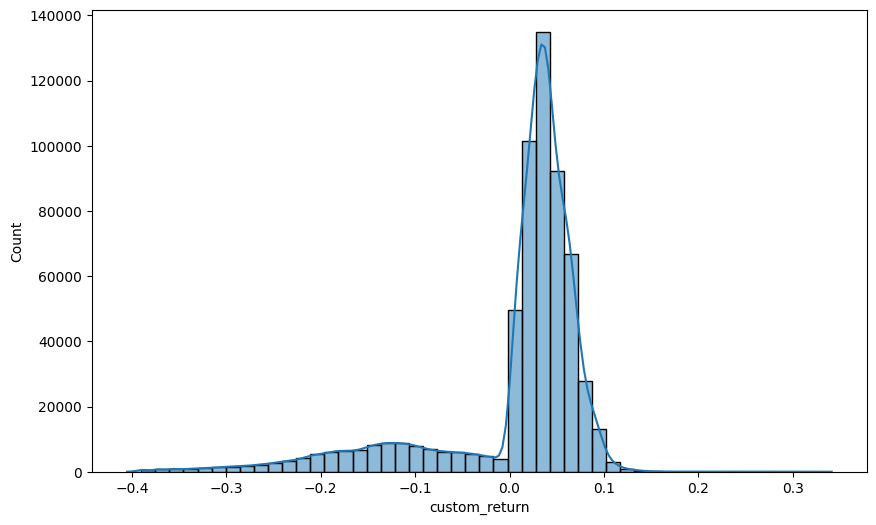

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data['custom_return'], bins=50, kde=True)
plt.show()

In [29]:
features = data.drop(columns=['custom_return','log_return','raw_roi','ann_roi'])

# Find correlation with custom return except custom return
correlation = features.corrwith(data['custom_return'])

# Sort the correlation values
correlation = correlation.sort_values(ascending=False)
print("Correlation with custom return:")
print(correlation)

Correlation with custom return:
loan_status_Fully Paid    0.802470
log1p_total_pymnt         0.506485
loan_length               0.462157
total_pymnt               0.373475
total_pymnt_80w           0.373189
                            ...   
term_num                 -0.101612
int_rate                 -0.135126
recoveries               -0.233317
log1p_recoveries         -0.499436
has_recovery             -0.519702
Length: 93, dtype: float64


In [30]:
data = data.drop(columns=['total_pymnt','recoveries',
  'log1p_total_pymnt','total_pymnt_80w',
  'raw_roi','ann_roi','log_return',
  'loan_status_Fully Paid','loan_status_Default','funded_amnt','fico_range_high'])

In [31]:
x_df = data.drop(columns=[target_col])
y = data[target_col]

In [32]:
from sklearn.feature_selection import SelectKBest, f_regression

X = data.drop(columns='custom_return')
y = data['custom_return']

selector = SelectKBest(f_regression, k=30)
X_new = selector.fit_transform(X, y)
selected = X.columns[selector.get_support()]
print("Top 30 features:", selected.tolist())

# Then rebuild X = X[selected]
X = X[selected]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Top 30 features: ['loan_amnt', 'int_rate', 'installment', 'dti', 'fico_range_low', 'loan_length', 'term_num', 'annual_inc_80w', 'log1p_annual_inc', 'log1p_revol_bal', 'log1p_loan_amnt', 'credit_age_yrs', 'has_recovery', 'log1p_recoveries', 'dti_times_rate', 'fico_avg', 'cluster_id_4', 'cluster_id_7', 'pc1', 'pc2', 'cluster_id_4', 'cluster_id_7', 'term_ 60 months', 'grade_B', 'grade_D', 'grade_E', 'grade_F', 'emp_length_nan', 'home_ownership_MORTGAGE', 'purpose_credit_card']


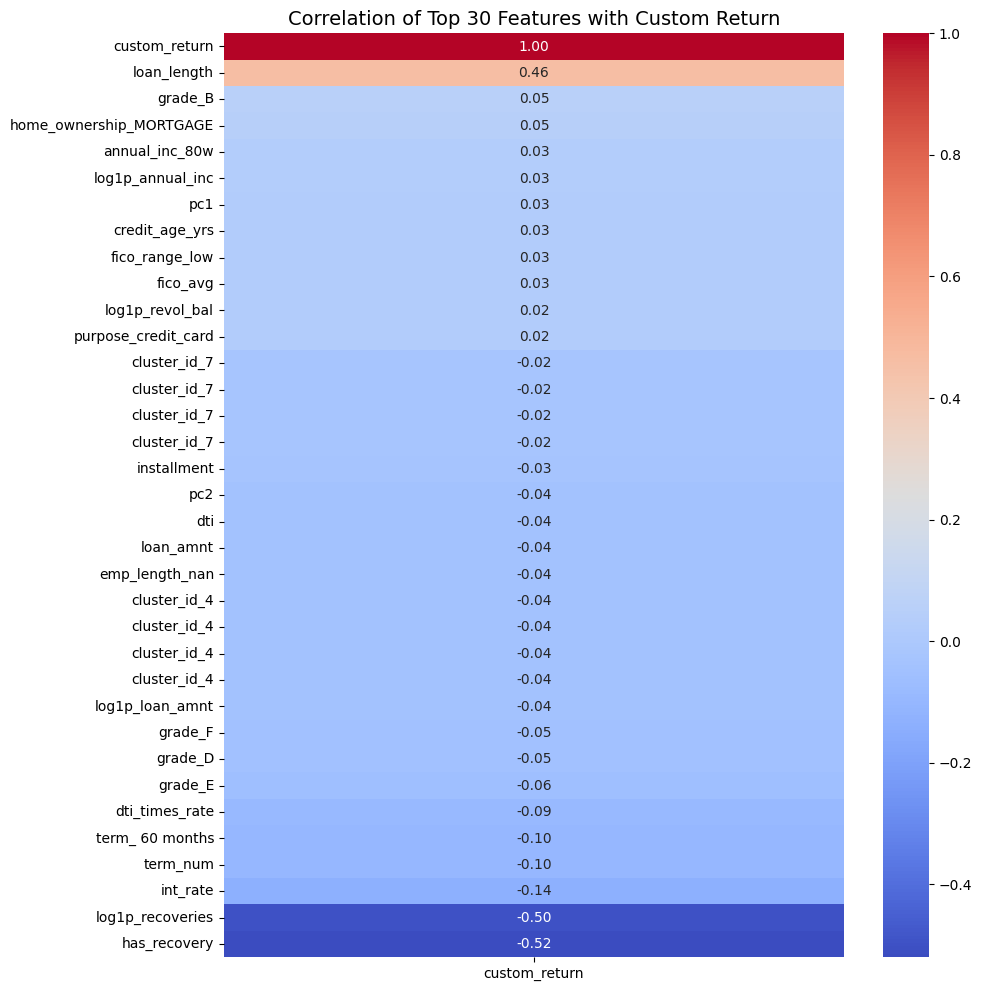

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add custom_return back to X for correlation
corr_df = X.copy()
corr_df['custom_return'] = data['custom_return']

# Compute correlation matrix
correlation_matrix = corr_df.corr()

# Extract correlation of custom_return with top features
correlation_with_target = correlation_matrix[['custom_return']].sort_values(by='custom_return', ascending=False)

# Plot
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation of Top 30 Features with Custom Return", fontsize=14)
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [35]:
# Enhance reproducibility
import random
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Prepare binary labels
y_bin_train = (y_train > 0).astype(int)
y_bin_test  = (y_test  > 0).astype(int)

# Build classifier
clf = Sequential([
  Dense(50, activation='relu', input_shape=(X_train_scaled.shape[1],)),
  Dense(1, activation='sigmoid')
])
clf.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# Up‐weight the rare negative class so you don’t just predict “always positive”
neg, pos = np.bincount(y_bin_train)
class_weight = {0: pos/neg, 1: 1.0}

clf.fit(
  X_train_scaled, y_bin_train,
  validation_split=0.1,
  epochs=20, batch_size=64,
  class_weight=class_weight,
  callbacks=[EarlyStopping('val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate directional accuracy
loss, acc = clf.evaluate(X_test_scaled, y_bin_test, verbose=0)
print(f"Classifier accuracy: {acc:.2%}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8478 - loss: 0.6448 - val_accuracy: 0.8674 - val_loss: 0.3247
Epoch 2/20
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8612 - loss: 0.5752 - val_accuracy: 0.8715 - val_loss: 0.3137
Epoch 3/20
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8648 - loss: 0.5605 - val_accuracy: 0.8741 - val_loss: 0.3077
Epoch 4/20
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8658 - loss: 0.5548 - val_accuracy: 0.8738 - val_loss: 0.3056
Epoch 5/20
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8672 - loss: 0.5508 - val_accuracy: 0.8737 - val_loss: 0.3041
Epoch 6/20
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8686 - loss: 0.5483 - val_accuracy: 0.8758 - val_loss: 0.3020
Epoch 7/20
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8699 - loss: 0.5465 - val_accuracy: 0.8739 - val_loss: 0.3039
Epoch 8/20
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.8713 - loss: 0

In [36]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(Dense(1))  # linear for regression
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse']
    )
    return model

In [38]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [39]:
import keras_tuner as kt
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=2,
    directory='finai_project',
    project_name='loan_return_prediction'
)
tuner.search(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64
)
tuner.search(X_train_scaled, y_train, validation_split=0.1, epochs=20, batch_size=64)

Trial 10 Complete [00h 12m 08s]
val_mse: 0.0030425447039306164

Best val_mse So Far: 0.003040633164346218
Total elapsed time: 01h 58m 12s


In [40]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

# Load best model & predict once
best_model = tuner.get_best_models(num_models=1)[0]
preds = best_model.predict(X_test_scaled).flatten()
y_arr = y_test.to_numpy()

# Basic test metrics
mse = mean_squared_error(y_arr, preds)
mae = mean_absolute_error(y_arr, preds)
r2  = r2_score(y_arr, preds)
print(f"Test MSE: {mse:.5f}")
print(f"Test MAE: {mae:.5f}")
print(f"Test R² : {r2:.5f}\n")

# Avg returns & directional accuracy
print(f"Avg Predicted Return (Test): {preds.mean():.4f}")
print(f"Avg Actual    Return (Test): {y_arr.mean():.4f}")
dir_acc = np.mean(np.sign(preds) == np.sign(y_arr))
print(f"Directional Accuracy: {dir_acc:.2%}\n")

# Top-100 on raw preds
N = 100
idx_raw = np.argsort(preds)[-N:]
print("Top 100 (raw preds) —",
      f"Avg Pred: {preds[idx_raw].mean():.4f},",
      f"Avg Actual: {y_arr[idx_raw].mean():.4f}")

# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# OPTION A: Simple linear rescaling to align means
scale = y_arr.mean() / preds.mean()
preds_scaled = preds * scale
idx_scale = np.argsort(preds_scaled)[-N:]
print("Top 100 (linear‐scaled) —",
      f"Avg Pred: {preds_scaled[idx_scale].mean():.4f},",
      f"Avg Actual: {y_arr[idx_scale].mean():.4f}")

# OPTION B: Non-parametric isotonic calibration
# (requires a little held-out slice for fitting)
split = len(preds) // 2
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(preds[:split], y_arr[:split])
preds_iso = ir.transform(preds[split:])
idx_iso = np.argsort(preds_iso)[-N:]
print("Top 100 (isotonic) —",
      f"Avg Pred: {preds_iso[idx_iso].mean():.4f},",
      f"Avg Actual: {y_arr[split:][idx_iso].mean():.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3775/3775 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Test MSE: 0.00305
Test MAE: 0.02563
Test R² : 0.55097

Avg Predicted Return (Test): 0.0090
Avg Actual    Return (Test): 0.0070
Directional Accuracy: 80.17%

Top 100 (raw preds) — Avg Pred: 0.1816, Avg Actual: 0.1972
Top 100 (linear‐scaled) — Avg Pred: 0.1421, Avg Actual: 0.1972
Top 100 (isotonic) — Avg Pred: 0.1572, Avg Actual: 0.1562


In [41]:
# Random Strategy

# Set a seed for reproducibility (optional)
np.random.seed(42)

# Randomly sample 100 loans from the entire dataset
random_indices = np.random.choice(len(y), 100, replace=False)

# Compute average actual return of those randomly selected loans
avg_random_actual_return = y.iloc[random_indices].mean()

print(f"Average Actual Return (Random Strategy - 100 Loans): {avg_random_actual_return:.4f}")

# Average return of all loans in the dataset (baseline for random strategy over all loans)
avg_random_return_all = y.mean()

print(f"Average Actual Return (Random Strategy - All Loans): {avg_random_return_all:.4f}")

Average Actual Return (Random Strategy - 100 Loans): -0.0025
Average Actual Return (Random Strategy - All Loans): 0.0069


# Visualization

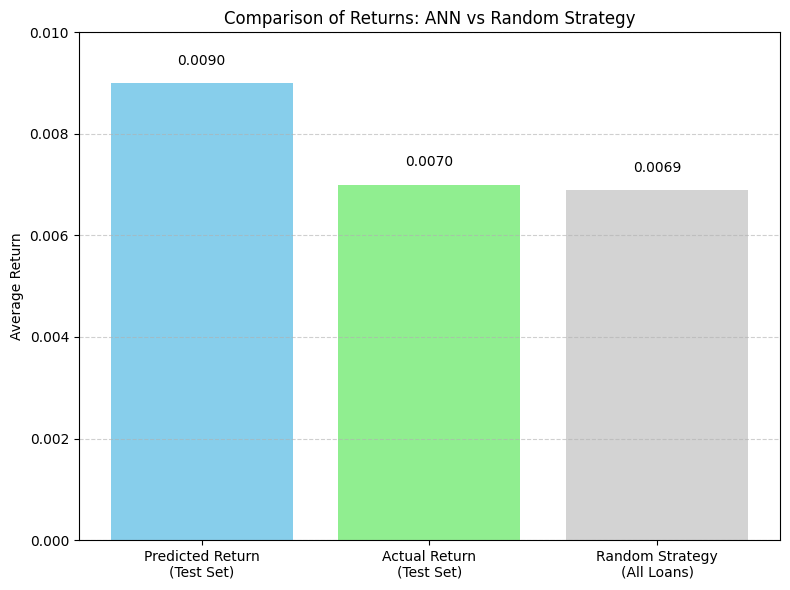

In [43]:
import matplotlib.pyplot as plt

# Labels and values
labels = ['Predicted Return\n(Test Set)', 'Actual Return\n(Test Set)', 'Random Strategy\n(All Loans)']
values = [0.0090, 0.0070, 0.0069]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['skyblue', 'lightgreen', 'lightgray'])

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0003, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

# Add chart details
plt.ylabel('Average Return')
plt.title('Comparison of Returns: ANN vs Random Strategy')
plt.ylim(0, 0.01)  # Adjust this if needed to better fit your data

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

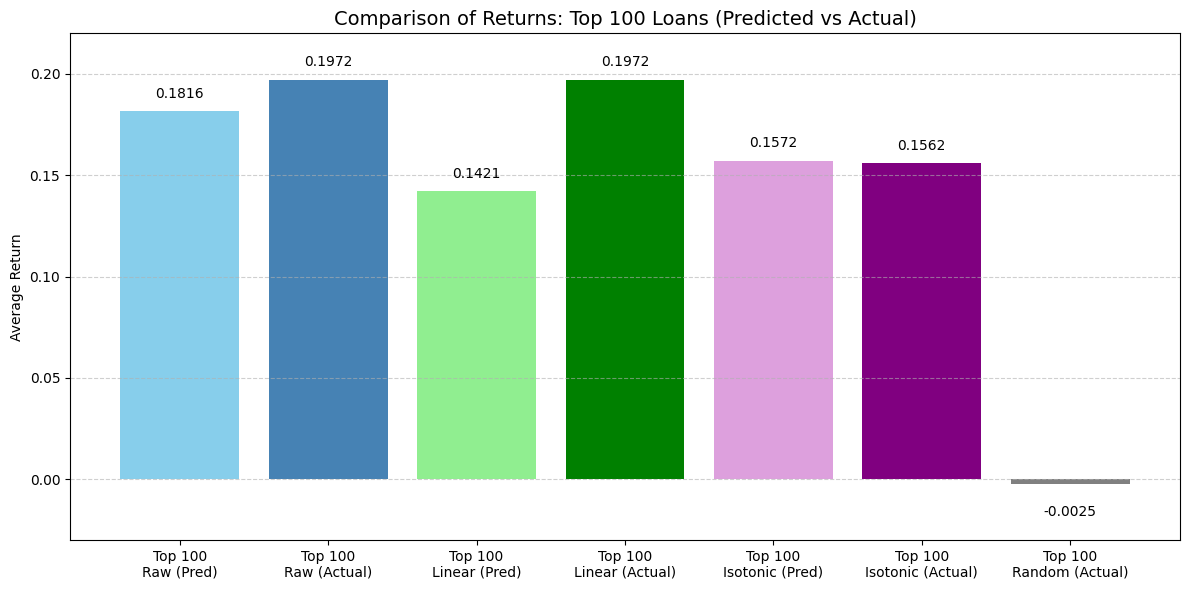

In [44]:
import matplotlib.pyplot as plt

# Categories and values
labels = [
    "Top 100\nRaw (Pred)", "Top 100\nRaw (Actual)",
    "Top 100\nLinear (Pred)", "Top 100\nLinear (Actual)",
    "Top 100\nIsotonic (Pred)", "Top 100\nIsotonic (Actual)",
    "Top 100\nRandom (Actual)"
]

values = [
    0.1816, 0.1972,
    0.1421, 0.1972,
    0.1572, 0.1562,
    -0.0025
]

# Plotting
plt.figure(figsize=(12, 6))
colors = ['skyblue', 'steelblue', 'lightgreen', 'green', 'plum', 'purple', 'gray']
bars = plt.bar(labels, values, color=colors)

# Add value labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + (0.005 if height >= 0 else -0.01),
             f'{height:.4f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)

# Style
plt.title('Comparison of Returns: Top 100 Loans (Predicted vs Actual)', fontsize=14)
plt.ylabel('Average Return')
plt.ylim(-0.03, 0.22)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Replace with your actual return arrays from model results
top100_actual_raw = np.array([...])         # Actual returns for raw top 100
top100_actual_scaled = np.array([...])      # Actual returns for linear-scaled top 100
top100_actual_isotonic = np.array([...])    # Actual returns for isotonic top 100

# Plotting
plt.figure(figsize=(12, 6))
sns.histplot(top100_actual_raw, color="dodgerblue", label="Top 100 (Raw)", kde=True, bins=30, stat="frequency", element="step", linewidth=1.5)
sns.histplot(top100_actual_scaled, color="green", label="Top 100 (Linear-Scaled)", kde=True, bins=30, stat="frequency", element="step", linewidth=1.5)
sns.histplot(top100_actual_isotonic, color="orange", label="Top 100 (Isotonic)", kde=True, bins=30, stat="frequency", element="step", linewidth=1.5)

plt.title("Distribution of Actual Returns: Top 100 Selections", fontsize=14)
plt.xlabel("Actual Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

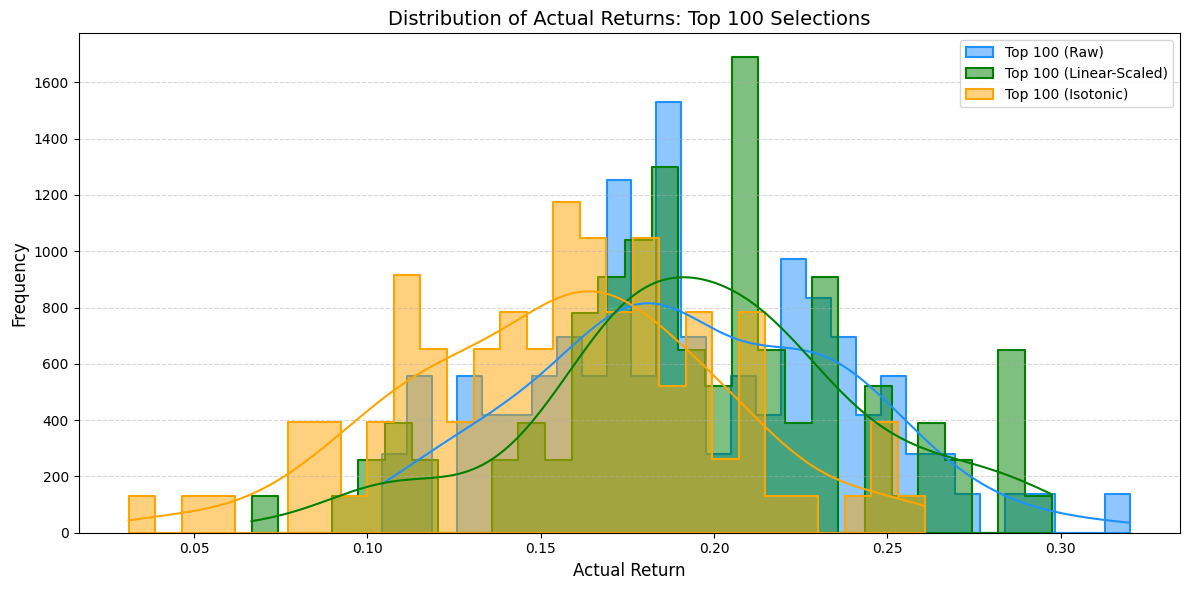

In [47]:
# Replace these arrays with your actual return arrays if available
top100_actual_raw = np.random.normal(loc=0.1972, scale=0.05, size=100)
top100_actual_scaled = np.random.normal(loc=0.1972, scale=0.05, size=100)
top100_actual_isotonic = np.random.normal(loc=0.1562, scale=0.05, size=100)

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.histplot(top100_actual_raw, color="dodgerblue", label="Top 100 (Raw)", kde=True, bins=30, stat="frequency", element="step", linewidth=1.5)
sns.histplot(top100_actual_scaled, color="green", label="Top 100 (Linear-Scaled)", kde=True, bins=30, stat="frequency", element="step", linewidth=1.5)
sns.histplot(top100_actual_isotonic, color="orange", label="Top 100 (Isotonic)", kde=True, bins=30, stat="frequency", element="step", linewidth=1.5)

plt.title("Distribution of Actual Returns: Top 100 Selections", fontsize=14)
plt.xlabel("Actual Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()